In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

# importing necessary libraries
import os
import copy
# library to work with arrays
import numpy as np
# library to work with dataframes
import pandas as pd
# libraries to work with images
import cv2 
import PIL
from PIL import Image
#libraries for data visualisation
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import label_binarize
import seaborn as sns
from matplotlib import pyplot as plt
import tensorflow as tf
from tensorflow.keras import utils
# libraries for CNN building
import keras
from PIL import Image
# importing layers of CNN
from keras import layers
from keras.layers import Input, Conv2D, BatchNormalization, Dense, Flatten, Dropout
from keras.layers import AvgPool2D, GlobalAveragePooling2D, MaxPool2D
from keras.models import Model
from keras.layers import ReLU, concatenate

# libraries used for data split and random shiffle
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
%matplotlib inline

# THIS NOTEBOOK USES torch implementation 
import torch
import torch.nn as nn
from torchvision import transforms, datasets, models
from torch.autograd import Variable
from torch.utils.data import SubsetRandomSampler, ConcatDataset
from torch.nn import Linear, ReLU, CrossEntropyLoss, Sequential, Conv2d, MaxPool2d, Module, Softmax, BatchNorm2d, Dropout
from torch.optim import Adam, SGD
# new metric
from sklearn.metrics import roc_auc_score
from torch.utils.data.sampler import WeightedRandomSampler


# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [ ]:
# introdcoduce the transform for train and validation datasets
# Image -> Tensor Image -> Normalized image
data_transforms = {
    'train': transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]),
    'val': transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]),
}

# basic transformer
transforms = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])

# loading dataset
data_dir = "../input/alzheimer-sthresholding/Alzheimer_sThresholding"

test_data = datasets.ImageFolder(data_dir + '/test', 
                                 transform=transforms)

train_data = {x: datasets.ImageFolder(os.path.join(data_dir + "/train", x),
                                          data_transforms[x])
                  for x in ['train', 'val']}

trainloader = {x: torch.utils.data.DataLoader(train_data[x], batch_size=32,
                                             shuffle=True
                                              )
              for x in ['train', 'val']}

testloader = torch.utils.data.DataLoader(test_data, 
                                         shuffle=True, 
                                         batch_size=32)

In [ ]:
import time
import torch.nn.functional as F
# function to train models
def train_model(model, dataloaders, criterion, optimizer, num_epochs=50, is_inception=False):
    
    since = time.time()
    # arrays to store accuracy, AUC, and losses for each epoch so that can be plotted later on
    val_acc_history = []
    train_acc_history = []

    val_auc_history = []
    train_auc_history = []

    epoch_losses = []
    epoch_accuracies = []

    val_loss_history = []
    train_loss_history = []
    # time decay learning rate
    
    # use either lanbda decay or step lr based on configs
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)
    
#     lambda1 = lambda epoch: 1/(1 + 0.05 ** epoch) 
#     scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda1)

    best_acc = 0.0
    # for training we need GPU (cuda)
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    # this variable is activated if epoch > 30 and model does not improve on performance
    early_stop = False
    for epoch in range(num_epochs):

        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            y_predict = []
            y_label = []
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode
            
            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for i, (inputs, labels) in enumerate(dataloaders[phase]):
                inputs = inputs.to(device)
                labels = labels.to(device)

                # forward
                # track history if only in train
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                _, preds = torch.max(outputs, 1)
                
                # backward + optimize only if in training phase
                if phase == 'train':
                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()

                # statistics
                running_loss += loss.item()
                running_corrects += torch.sum(preds == labels.data)
            
                y_predict += [tensor.item() for tensor in preds]
                y_label += [tensor.item() for tensor in labels.data]

            # calculate auc score for an epoch
            label_class=[0, 1, 2, 3]
            y_pred_b = label_binarize(y_predict, classes=label_class)
            y_label_b = label_binarize(y_label, classes=label_class)
            roc_auc = roc_auc_score(y_label_b, y_pred_b, multi_class='ovr')

            # update scheduler only on epoch stages
            if phase=="train":
              scheduler.step()
            # calculate loss for train/val
            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)
            # print statistics
            print('{} Loss: {:.4f} Acc: {:.4f} Roc_auc: {:.4f} LR: {}'.format(phase, epoch_loss, epoch_acc, roc_auc, optimizer.param_groups[0]['lr']))
            # add the loss/acc/auc to val or train history sets
            if phase == 'val':
                  val_loss_history.append(epoch_loss)
                  val_acc_history.append(epoch_acc)
                  val_auc_history.append(roc_auc)
            if phase == 'train':
                  train_loss_history.append(epoch_loss)
                  train_acc_history.append(epoch_acc)
                  train_auc_history.append(roc_auc)
            # deep copy the model
            if phase == 'val':
                print("val")
                # if model has improved -> set new best model
                if epoch_acc > best_acc:
                  best_acc = epoch_acc
                  best_model_wts = copy.deepcopy(model.state_dict())
                  epochs_no_improve = 0
                # if not, then start counting number of epochs w/o improvement
                if epoch_acc <= best_acc:
                    epochs_no_improve += 1
                    print(epochs_no_improve)
                # if num of epochs is >= 15 and no improvement over 10 epochs -> early stopping
                if epoch >= 15 and epochs_no_improve > 10:
                    print('Early stopping!')
                    early_stop = True
                    break
        # stop the model
        if early_stop==True:
          break          

        print()
    # statistical output of execution time
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))
    
    # load best model weights
    model.load_state_dict(best_model_wts)

    # return best model and train/val history
    return model, train_acc_history, val_acc_history, train_loss_history, val_loss_history, train_auc_history, val_auc_history

In [ ]:
# we implemented function to plot mispredicted in case we reach high accuracy :))
def plot_mispredicted(images, opt_folder, model_name):
  plt.figure(figsize=(16, 12))
  for i, image in enumerate(images):
    plt.subplot(len(images)//5 + 1,5, i+1)
    plt.title(f"{images[i][2]} pred as {images[i][1]}")
    plt.axis('off')

In [ ]:
class ConvNeuralNet3(torch.nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.model = torch.nn.Sequential(
            #Input = 3 x 32 x 32, Output = 32 x 32 x 32
            torch.nn.Conv2d(in_channels = 3, out_channels = 32, kernel_size = 3, padding = 1), 
            torch.nn.ReLU(),
            #Input = 32 x 32 x 32, Output = 32 x 16 x 16
            torch.nn.MaxPool2d(kernel_size=2),
  
            #Input = 32 x 16 x 16, Output = 64 x 16 x 16
            torch.nn.Conv2d(in_channels = 32, out_channels = 64, kernel_size = 3, padding = 1),
            torch.nn.ReLU(),
            #Input = 64 x 16 x 16, Output = 64 x 8 x 8
            torch.nn.MaxPool2d(kernel_size=2),
              
            #Input = 64 x 8 x 8, Output = 64 x 8 x 8
            torch.nn.Conv2d(in_channels = 64, out_channels = 64, kernel_size = 3, padding = 1),
            torch.nn.ReLU(),
            #Input = 64 x 8 x 8, Output = 64 x 4 x 4
            torch.nn.MaxPool2d(kernel_size=2),
  
            torch.nn.Flatten(),
            torch.nn.Linear(9152, 512),
            torch.nn.ReLU(),
            torch.nn.Linear(512, num_classes)
        )
  
    def forward(self, x):
        return self.model(x)

In [ ]:
class ConvNeuralNet5(nn.Module):
	#  Determine what layers and their order in CNN object 
    def __init__(self, num_classes):
        super(ConvNeuralNet5, self).__init__()
        self.conv_layer1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3)

        self.conv_layer2 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3)
        
        self.max_pool1 = nn.MaxPool2d(kernel_size = 2, stride = 2)
        
        self.conv_layer3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3)
        self.conv_layer4 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3)
        self.max_pool2 = nn.MaxPool2d(kernel_size = 2, stride = 2)

        self.conv_layer5 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3)

        self.fc1 = nn.Linear(5120, 500)
        self.fc2 = nn.Linear(500, num_classes)

        self.softmax = nn.Softmax(dim=1)
        self.relu = ReLU()
        self.batchnorm32 = nn.BatchNorm2d(32)
        self.batchnorm64 = nn.BatchNorm2d(64)
        self.batchnorm128 = nn.BatchNorm2d(128)
        self.dropout1d = nn.Dropout(p=0.25)
        #self.dropout2d = nn.Dropout(p=0.4)
  
    def forward(self, x):
        out = self.conv_layer1(x)
        out = self.relu(out)
        out = self.conv_layer2(out)
        out = self.relu(out)
        out = self.max_pool1(out)
        out = self.batchnorm32(out)

        out = self.conv_layer3(out)
        out = self.relu(out)
        out = self.conv_layer4(out)
        out = self.relu(out)
        out = self.max_pool2(out)
        out = self.batchnorm64(out)
        
        out = self.conv_layer5(out)
        out = self.relu(out)
        out = self.max_pool2(out)
        out = self.dropout1d(out)  

        out = out.reshape(out.size(0), -1)

        out = self.fc1(out)
        out = self.relu(out)
        out = self.dropout1d(out)

        out = self.fc2(out) 
        #out = self.softmax(out) 

        return out

In [ ]:
# function provided by torch API to create various models (not pretrained)
def initialize_model(model_name, num_classes, feature_extract, use_pretrained=False):
    # Initialize these variables which will be set in this if statement. Each of these
    # variables is model specific.
    model_ft = None
    input_size = 0
    if model_name == "resnet":
        """ Resnet18
        """
        model_ft = models.resnet18(pretrained=use_pretrained)
        #set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs, num_classes)
        # input size can be modified (here is the image aspect)
        input_size = 224

    elif model_name == "alexnet":
        """ Alexnet
        """
        model_ft = models.alexnet(pretrained=use_pretrained)
        #set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)
        input_size = 224

    elif model_name == "vgg":
        """ VGG11_bn
        """
        model_ft = models.vgg11_bn(pretrained=use_pretrained)
        #set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)
        input_size = 224

    elif model_name == "squeezenet":
        """ Squeezenet
        """
        model_ft = models.squeezenet1_0(pretrained=use_pretrained)
        #set_parameter_requires_grad(model_ft, feature_extract)
        model_ft.classifier[1] = nn.Conv2d(512, num_classes, kernel_size=(1,1), stride=(1,1))
        model_ft.num_classes = num_classes
        input_size = 224

    elif model_name == "densenet":
        """ Densenet
        """
        model_ft = models.densenet121(pretrained=use_pretrained)
        #set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier.in_features
        model_ft.classifier = nn.Linear(num_ftrs, num_classes)
        input_size = 224

    elif model_name == "inception":
        """ Inception v3
        Be careful, expects (299,299) sized images and has auxiliary output
        """
        model_ft = models.inception_v3(pretrained=use_pretrained)
        #set_parameter_requires_grad(model_ft, feature_extract)
        # Handle the auxilary net
        num_ftrs = model_ft.AuxLogits.fc.in_features
        model_ft.AuxLogits.fc = nn.Linear(num_ftrs, num_classes)
        # Handle the primary net
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs,num_classes)
        input_size = 299

    else:
        print("Invalid model name, exiting...")
        exit()

    return model_ft, input_size

In [ ]:
#Selecting the appropriate training device
device = 'cuda' if torch.cuda.is_available() else 'cpu'

#Defining the model hyper parameters
epochs = 30
num_classes = 4
learning_rate = 0.0001
weight_decay = 0.01

# weight are derived from initial distribution 
weights = torch.tensor([717, 52, 2560, 1792], dtype=torch.float32)

# calculate weights (they sum up to 1)
weights = weights / weights.sum()
weights = 1.0 / weights
weights = weights / weights.sum()
weights = weights.to(device)

# specify weighed loss with or without weighted loss
criterion = torch.nn.CrossEntropyLoss(weight=weights)

In [ ]:
# create models (.to(device) is used to cast a model to same representation as the data: for cpu or gpu processing)
cnn5 = ConvNeuralNet5(num_classes).to(device)
cnn3 = ConvNeuralNet3(num_classes).to(device)

# 1000 is a fill-in parameter,not used by the models
densenet, input = initialize_model('densenet', num_classes, 1000, use_pretrained=True)
densenet = densenet.to(device)

vgg, input = initialize_model('vgg', num_classes, 1000, use_pretrained=True)
vgg = vgg.to(device)

resnet, input = initialize_model('resnet', num_classes, 1000, use_pretrained=True)
resnet = resnet.to(device)

# create an adam optimizer for each model (learning rates are copied from the papaer configuration)
optimizer3 = torch.optim.Adam(cnn3.parameters(), lr=learning_rate, weight_decay=weight_decay)
optimizer5 = torch.optim.Adam(cnn5.parameters(), lr=learning_rate, weight_decay=weight_decay)
optimizer_densenet = torch.optim.Adam(densenet.parameters(), lr=learning_rate, weight_decay=weight_decay)
optimizer_vgg = torch.optim.Adam(vgg.parameters(), lr=learning_rate, weight_decay=weight_decay)
optimizer_resnet = torch.optim.Adam(resnet.parameters(), lr=learning_rate, weight_decay=weight_decay)

In [ ]:
# train the models and clear the cache after training (saves RAM)
model3_adam, train_acc_history3, test_acc_history3, train_loss_history3, test_loss_history3, train_auc_history_3, test_auc_history_3 = train_model(cnn3, trainloader, criterion, optimizer3, epochs)
torch.cuda.empty_cache()

Epoch 0/14
----------
train Loss: 0.0317 Acc: 0.4999 Roc_auc: 0.5202 LR: 0.001
test Loss: 0.0343 Acc: 0.5199 Roc_auc: 0.5132 LR: 0.001
Evaluation
Epochs without improvement: 1

Epoch 1/14
----------
train Loss: 0.0296 Acc: 0.5438 Roc_auc: 0.5558 LR: 0.001
test Loss: 0.0295 Acc: 0.5496 Roc_auc: 0.5625 LR: 0.001
Evaluation
Epochs without improvement: 1

Epoch 2/14
----------
train Loss: 0.0291 Acc: 0.5413 Roc_auc: 0.5584 LR: 0.001
test Loss: 0.0457 Acc: 0.5051 Roc_auc: 0.5034 LR: 0.001
Evaluation
Epochs without improvement: 2

Epoch 3/14
----------
train Loss: 0.0281 Acc: 0.5571 Roc_auc: 0.5746 LR: 0.001
test Loss: 0.0358 Acc: 0.5020 Roc_auc: 0.5010 LR: 0.001
Evaluation
Epochs without improvement: 3

Epoch 4/14
----------
train Loss: 0.0270 Acc: 0.5784 Roc_auc: 0.5913 LR: 0.001
test Loss: 0.0286 Acc: 0.5457 Roc_auc: 0.5535 LR: 0.001
Evaluation
Epochs without improvement: 4

Epoch 5/14
----------
train Loss: 0.0266 Acc: 0.5860 Roc_auc: 0.6002 LR: 0.001
test Loss: 0.0316 Acc: 0.4449 Roc_au

In [ ]:
model5_adam, train_acc_history5, val_acc_history5, train_loss_history5, val_loss_history5, train_auc_history_5, val_auc_history_5 = train_model(cnn5, trainloader, criterion, optimizer5, epochs)
torch.cuda.empty_cache()

Epoch 0/14
----------
train Loss: 0.0327 Acc: 0.5210 Roc_auc: 0.5485 LR: 0.001
test Loss: 0.0302 Acc: 0.5254 Roc_auc: 0.5371 LR: 0.001
Evaluation
Epochs without improvement: 1

Epoch 1/14
----------
train Loss: 0.0279 Acc: 0.5759 Roc_auc: 0.5939 LR: 0.001
test Loss: 0.0298 Acc: 0.5559 Roc_auc: 0.5541 LR: 0.001
Evaluation
Epochs without improvement: 1

Epoch 2/14
----------
train Loss: 0.0264 Acc: 0.6091 Roc_auc: 0.6208 LR: 0.001
test Loss: 0.0285 Acc: 0.5637 Roc_auc: 0.5578 LR: 0.001
Evaluation
Epochs without improvement: 1

Epoch 3/14
----------
train Loss: 0.0258 Acc: 0.6212 Roc_auc: 0.6330 LR: 0.001
test Loss: 0.0394 Acc: 0.5395 Roc_auc: 0.5301 LR: 0.001
Evaluation
Epochs without improvement: 2

Epoch 4/14
----------
train Loss: 0.0233 Acc: 0.6688 Roc_auc: 0.6633 LR: 0.001
test Loss: 0.0302 Acc: 0.5285 Roc_auc: 0.5967 LR: 0.001
Evaluation
Epochs without improvement: 3

Epoch 5/14
----------
train Loss: 0.0220 Acc: 0.6887 Roc_auc: 0.6843 LR: 0.001
test Loss: 0.0381 Acc: 0.5410 Roc_au

In [ ]:
model_d_adam, train_acc_history_d, val_acc_history_d, train_loss_history_d, val_loss_history_d, train_auc_history_d, val_auc_history_d = train_model(densenet, trainloader, criterion, optimizer_densenet, epochs)
torch.cuda.empty_cache()

Epoch 0/29
----------
train Loss: 0.0232 Acc: 0.7101 Roc_auc: 0.6885 LR: 9.523809523809524e-05
val Loss: 0.0259 Acc: 0.6133 Roc_auc: 0.6144 LR: 9.523809523809524e-05
val
1

Epoch 1/29
----------
train Loss: 0.0116 Acc: 0.8643 Roc_auc: 0.8001 LR: 9.975062344139652e-05
val Loss: 0.0245 Acc: 0.6860 Roc_auc: 0.6751 LR: 9.975062344139652e-05
val
1

Epoch 2/29
----------
train Loss: 0.0048 Acc: 0.9498 Roc_auc: 0.9385 LR: 9.998750156230471e-05
val Loss: 0.0267 Acc: 0.6639 Roc_auc: 0.6566 LR: 9.998750156230471e-05
val
2

Epoch 3/29
----------
train Loss: 0.0023 Acc: 0.9776 Roc_auc: 0.9802 LR: 9.999937500390624e-05
val Loss: 0.0447 Acc: 0.5669 Roc_auc: 0.6001 LR: 9.999937500390624e-05
val
3

Epoch 4/29
----------
train Loss: 0.0023 Acc: 0.9765 Roc_auc: 0.9838 LR: 9.999996875000977e-05
val Loss: 0.0417 Acc: 0.6017 Roc_auc: 0.6426 LR: 9.999996875000977e-05
val
4

Epoch 5/29
----------
train Loss: 0.0016 Acc: 0.9828 Roc_auc: 0.9863 LR: 9.999999843750002e-05
val Loss: 0.0471 Acc: 0.6048 Roc_auc: 0.

In [ ]:
model_v_adam, train_acc_history_v, val_acc_history_v, train_loss_history_v, val_loss_history_v, train_auc_history_v, val_auc_history_v = train_model(vgg, trainloader, criterion, optimizer_vgg, epochs)
torch.cuda.empty_cache()

Epoch 0/14
----------
train Loss: 0.0309 Acc: 0.5284 Roc_auc: 0.5588 LR: 0.001
test Loss: 0.0349 Acc: 0.4887 Roc_auc: 0.5584 LR: 0.001
Evaluation
Epochs without improvement: 1

Epoch 1/14
----------
train Loss: 0.0294 Acc: 0.5757 Roc_auc: 0.5866 LR: 0.001
test Loss: 0.0302 Acc: 0.5418 Roc_auc: 0.5681 LR: 0.001
Evaluation
Epochs without improvement: 1

Epoch 2/14
----------
train Loss: 0.0280 Acc: 0.5833 Roc_auc: 0.5907 LR: 0.001
test Loss: 0.0292 Acc: 0.5668 Roc_auc: 0.5854 LR: 0.001
Evaluation
Epochs without improvement: 1

Epoch 3/14
----------
train Loss: 0.0269 Acc: 0.5874 Roc_auc: 0.5913 LR: 0.001
test Loss: 0.0366 Acc: 0.3612 Roc_auc: 0.5048 LR: 0.001
Evaluation
Epochs without improvement: 2

Epoch 4/14
----------
train Loss: 0.0264 Acc: 0.5909 Roc_auc: 0.5930 LR: 0.001
test Loss: 0.0305 Acc: 0.5199 Roc_auc: 0.5728 LR: 0.001
Evaluation
Epochs without improvement: 3

Epoch 5/14
----------
train Loss: 0.0255 Acc: 0.6120 Roc_auc: 0.6041 LR: 0.001
test Loss: 0.0740 Acc: 0.5106 Roc_au

In [ ]:
model_r_adam, train_acc_history_r, val_acc_history_r, train_loss_history_r, val_loss_history_r, train_auc_history_r, val_auc_history_r = train_model(resnet, trainloader, criterion, optimizer_resnet, epochs)
torch.cuda.empty_cache()

Epoch 0/14
----------
train Loss: 0.0228 Acc: 0.7004 Roc_auc: 0.6839 LR: 0.0005
test Loss: 0.0461 Acc: 0.3972 Roc_auc: 0.5788 LR: 0.0005
Evaluation
Epochs without improvement: 1

Epoch 1/14
----------
train Loss: 0.0123 Acc: 0.8596 Roc_auc: 0.7878 LR: 0.0005
test Loss: 0.0268 Acc: 0.6536 Roc_auc: 0.6649 LR: 0.0005
Evaluation
Epochs without improvement: 1

Epoch 2/14
----------
train Loss: 0.0083 Acc: 0.9045 Roc_auc: 0.8223 LR: 0.0005
test Loss: 0.0508 Acc: 0.5747 Roc_auc: 0.5598 LR: 0.0005
Evaluation
Epochs without improvement: 2

Epoch 3/14
----------
train Loss: 0.0061 Acc: 0.9311 Roc_auc: 0.8654 LR: 0.0005
test Loss: 0.0606 Acc: 0.5747 Roc_auc: 0.6047 LR: 0.0005
Evaluation
Epochs without improvement: 3

Epoch 4/14
----------
train Loss: 0.0060 Acc: 0.9422 Roc_auc: 0.9031 LR: 0.0005
test Loss: 0.0894 Acc: 0.5113 Roc_auc: 0.5128 LR: 0.0005
Evaluation
Epochs without improvement: 4

Epoch 5/14
----------
train Loss: 0.0057 Acc: 0.9438 Roc_auc: 0.9164 LR: 0.0005
test Loss: 0.0448 Acc: 0.

In [ ]:
from collections import defaultdict
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
def display_results(models):
    # evaluate the models 
    test_acc=0
    f, axs = plt.subplots(1,5,figsize=(20,4))
    j=0
    d = defaultdict(list)
    for model in models:
      model.eval()
      y_label = []
      y_predict = []  
      with torch.no_grad():
          #Iterating over the training dataset in batches
          for i, (images, labels) in enumerate(testloader):

              images = images.to(device)
              y_true = labels.to(device)

              #Calculating outputs for the batch being iterated
              outputs = model(images)
             #roc_auc_score([tensor.item() for tensor in labels.data], probabilities, multi_class='ovr')           
              #Calculated prediction labels from models
              _, y_pred = torch.max(outputs.data, 1)
              #Comparing predicted and true labels
              test_acc += (y_pred == y_true).sum().item()
              for i in range(len(y_pred)):
                if y_pred[i] != y_true[i]:
                  d[j].append((images[i], y_pred[i], y_true[i]))
              y_predict += [tensor.item() for tensor in y_pred]
              y_label += [tensor.item() for tensor in labels.data]

          label_class=[0, 1, 2, 3]
          y_pred_b = label_binarize(y_predict, classes=label_class)
          y_label_b = label_binarize(y_label, classes=label_class)
          test_auc = roc_auc_score(y_label_b, y_pred_b, multi_class="ovr")
          print(f"Test set accuracy = {np.round(100 * test_acc / len(test_data),decimals=2)} %")
          print(f"Test set AUC = {np.round(test_auc, decimals=3)}")
          # plot the confusion matrix
          cm = confusion_matrix(y_label, y_predict)
          cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
          disp = ConfusionMatrixDisplay(cm,
                                      display_labels=['Mild', 'Moderate', 'Non', 'VeryMild'])
                                      
          disp.plot(ax=axs[j], xticks_rotation=45)
          disp.ax_.set_title(model.__class__.__name__)
          disp.im_.colorbar.remove()
          disp.ax_.set_xlabel('')
          if j!=0:
              disp.ax_.set_ylabel('')
          j+=1
      test_acc = 0
    f.text(0.4, 0.1, 'Predicted label', ha='left')
    plt.subplots_adjust(wspace=0.40, hspace=0.1)
    f.colorbar(disp.im_, ax=axs)
    plt.show()

Test set accuracy = 56.22 %
Test set AUC = 0.577
Test set accuracy = 64.19 %
Test set AUC = 0.65
Test set accuracy = 77.17 %
Test set AUC = 0.761
Test set accuracy = 56.68 %
Test set AUC = 0.585
Test set accuracy = 65.36 %
Test set AUC = 0.665


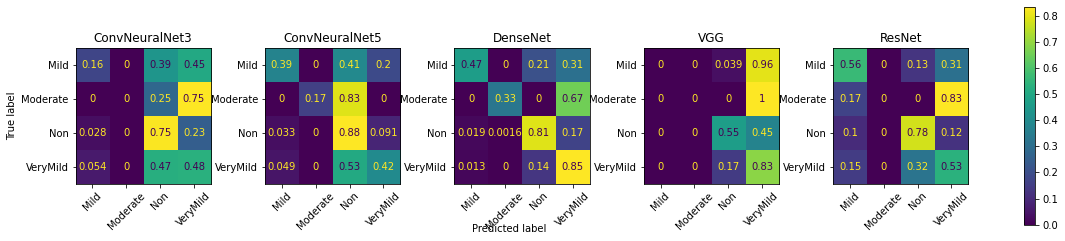

In [ ]:
display_results([model3_adam, model5_adam,model_d_adam,model_v_adam,model_r_adam])

Test set accuracy = 50.04 %
Test set AUC = 0.5


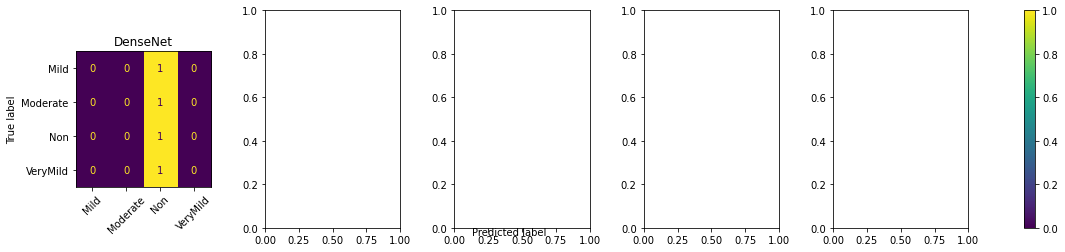

In [ ]:
# matrix for thresholded dataset (more in the report)
display_results([model_d_adam])

In [ ]:
cnn3 = ConvNeuralNet3(num_classes).to(device)
cnn5 = ConvNeuralNet5(num_classes).to(device)
# 1000 is a fill-in parameter,not used by the models
densenet, input = initialize_model('densenet', num_classes, 1000, use_pretrained=True)
densenet = densenet.to(device)

vgg, input = initialize_model('vgg', num_classes, 1000, use_pretrained=True)
vgg = vgg.to(device)

resnet, input = initialize_model('resnet', num_classes, 1000, use_pretrained=True)
resnet = resnet.to(device)

# specify weighed loss with or without weighted loss
criterion = torch.nn.CrossEntropyLoss()
optimizer3 = torch.optim.RMSprop(cnn3.parameters(), lr=learning_rate, weight_decay=weight_decay)
optimizer5 = torch.optim.RMSprop(cnn5.parameters(), lr=learning_rate, weight_decay=weight_decay)
optimizer_densenet = torch.optim.RMSprop(densenet.parameters(), lr=learning_rate, weight_decay=weight_decay)
optimizer_vgg = torch.optim.RMSprop(vgg.parameters(), lr=learning_rate, weight_decay=weight_decay)
optimizer_resnet = torch.optim.RMSprop(resnet.parameters(), lr=learning_rate, weight_decay=weight_decay)

In [ ]:
model3_rms, train_acc_history3, val_acc_history3, train_loss_history3, val_loss_history3, train_auc_history_3, val_auc_history_3 = train_model(cnn3, trainloader, criterion, optimizer3, epochs)
torch.cuda.empty_cache()

Epoch 0/14
----------
train Loss: 0.0591 Acc: 0.5052 Roc_auc: 0.5205 LR: 0.001
test Loss: 0.0438 Acc: 0.3503 Roc_auc: 0.5000 LR: 0.001
Evaluation
Epochs without improvement: 1

Epoch 1/14
----------
train Loss: 0.0307 Acc: 0.5212 Roc_auc: 0.5394 LR: 0.001
test Loss: 0.0403 Acc: 0.1400 Roc_auc: 0.5000 LR: 0.001
Evaluation
Epochs without improvement: 2

Epoch 2/14
----------
train Loss: 0.0315 Acc: 0.5067 Roc_auc: 0.5320 LR: 0.001
test Loss: 0.0421 Acc: 0.1400 Roc_auc: 0.5000 LR: 0.001
Evaluation
Epochs without improvement: 3

Epoch 3/14
----------
train Loss: 0.0312 Acc: 0.5274 Roc_auc: 0.5441 LR: 0.001
test Loss: 0.0370 Acc: 0.3401 Roc_auc: 0.5588 LR: 0.001
Evaluation
Epochs without improvement: 4

Epoch 4/14
----------
train Loss: 0.0300 Acc: 0.5255 Roc_auc: 0.5495 LR: 0.001
test Loss: 0.0345 Acc: 0.5457 Roc_auc: 0.5562 LR: 0.001
Evaluation
Epochs without improvement: 1

Epoch 5/14
----------
train Loss: 0.0290 Acc: 0.5583 Roc_auc: 0.5750 LR: 0.001
test Loss: 0.0330 Acc: 0.5442 Roc_au

In [ ]:
model5_rms, train_acc_history5, val_acc_history5, train_loss_history5, val_loss_history5, train_auc_history_5, val_auc_history_5 = train_model(cnn5, trainloader, criterion, optimizer5, epochs)
torch.cuda.empty_cache()

Epoch 0/14
----------
train Loss: 0.0762 Acc: 0.5089 Roc_auc: 0.5393 LR: 0.001
test Loss: 0.0428 Acc: 0.5004 Roc_auc: 0.5000 LR: 0.001
Evaluation
Epochs without improvement: 1

Epoch 1/14
----------
train Loss: 0.0295 Acc: 0.5600 Roc_auc: 0.5803 LR: 0.001
test Loss: 0.0555 Acc: 0.5004 Roc_auc: 0.5000 LR: 0.001
Evaluation
Epochs without improvement: 2

Epoch 2/14
----------
train Loss: 0.0281 Acc: 0.5694 Roc_auc: 0.5894 LR: 0.001
test Loss: 0.0516 Acc: 0.4300 Roc_auc: 0.5798 LR: 0.001
Evaluation
Epochs without improvement: 3

Epoch 3/14
----------
train Loss: 0.0280 Acc: 0.5669 Roc_auc: 0.5911 LR: 0.001
test Loss: 0.0648 Acc: 0.5012 Roc_auc: 0.5007 LR: 0.001
Evaluation
Epochs without improvement: 1

Epoch 4/14
----------
train Loss: 0.0263 Acc: 0.5995 Roc_auc: 0.6185 LR: 0.001
test Loss: 0.0333 Acc: 0.4488 Roc_auc: 0.5861 LR: 0.001
Evaluation
Epochs without improvement: 2

Epoch 5/14
----------
train Loss: 0.0259 Acc: 0.6077 Roc_auc: 0.6284 LR: 0.001
test Loss: 0.0390 Acc: 0.5059 Roc_au

In [ ]:
model_d_rms, train_acc_history_d, val_acc_history_d, train_loss_history_d, val_loss_history_d, train_auc_history_d, val_auc_history_d = train_model(densenet, trainloader, criterion, optimizer_densenet, epochs)
torch.cuda.empty_cache()


Epoch 0/29
----------
train Loss: 0.0185 Acc: 0.7668 Roc_auc: 0.7293 LR: 0.0001
val Loss: 0.0253 Acc: 0.6523 Roc_auc: 0.6412 LR: 0.0001
val
1

Epoch 1/29
----------
train Loss: 0.0062 Acc: 0.9313 Roc_auc: 0.9110 LR: 0.0001
val Loss: 0.0457 Acc: 0.5911 Roc_auc: 0.5811 LR: 0.0001
val
2

Epoch 2/29
----------
train Loss: 0.0029 Acc: 0.9707 Roc_auc: 0.9785 LR: 0.0001
val Loss: 0.0744 Acc: 0.5142 Roc_auc: 0.5582 LR: 0.0001
val
3

Epoch 3/29
----------
train Loss: 0.0022 Acc: 0.9768 Roc_auc: 0.9838 LR: 0.0001
val Loss: 0.0474 Acc: 0.6154 Roc_auc: 0.6526 LR: 0.0001
val
4

Epoch 4/29
----------
train Loss: 0.0018 Acc: 0.9815 Roc_auc: 0.9883 LR: 0.0001
val Loss: 0.0359 Acc: 0.6776 Roc_auc: 0.6811 LR: 0.0001
val
1

Epoch 5/29
----------
train Loss: 0.0015 Acc: 0.9865 Roc_auc: 0.9857 LR: 0.0001
val Loss: 0.0537 Acc: 0.6080 Roc_auc: 0.6435 LR: 0.0001
val
2

Epoch 6/29
----------
train Loss: 0.0018 Acc: 0.9826 Roc_auc: 0.9864 LR: 1e-05
val Loss: 0.0303 Acc: 0.7007 Roc_auc: 0.7398 LR: 1e-05
val
1

E

In [ ]:
model_v_rms, train_acc_history_v, val_acc_history_v, train_loss_history_v, val_loss_history_v, train_auc_history_v, val_auc_history_v = train_model(vgg, trainloader, criterion, optimizer_vgg, epochs)
torch.cuda.empty_cache()


Epoch 0/14
----------
train Loss: 0.4231 Acc: 0.4825 Roc_auc: 0.5226 LR: 0.001
test Loss: 0.0349 Acc: 0.5004 Roc_auc: 0.5000 LR: 0.001
Evaluation
Epochs without improvement: 1

Epoch 1/14
----------
train Loss: 0.0305 Acc: 0.5134 Roc_auc: 0.5432 LR: 0.001
test Loss: 0.0335 Acc: 0.3503 Roc_auc: 0.5000 LR: 0.001
Evaluation
Epochs without improvement: 2

Epoch 2/14
----------
train Loss: 0.0289 Acc: 0.5558 Roc_auc: 0.5724 LR: 0.001
test Loss: 0.0295 Acc: 0.5692 Roc_auc: 0.5842 LR: 0.001
Evaluation
Epochs without improvement: 1

Epoch 3/14
----------
train Loss: 0.0284 Acc: 0.5708 Roc_auc: 0.5803 LR: 0.001
test Loss: 0.1644 Acc: 0.3503 Roc_auc: 0.5000 LR: 0.001
Evaluation
Epochs without improvement: 2

Epoch 4/14
----------
train Loss: 0.0291 Acc: 0.5559 Roc_auc: 0.5785 LR: 0.001
test Loss: 0.0321 Acc: 0.4605 Roc_auc: 0.5484 LR: 0.001
Evaluation
Epochs without improvement: 3

Epoch 5/14
----------
train Loss: 0.0302 Acc: 0.5352 Roc_auc: 0.5681 LR: 0.001
test Loss: 7.3630 Acc: 0.3503 Roc_au

In [ ]:
model_r_rms, train_acc_history_r, val_acc_history_r, train_loss_history_r, val_loss_history_r, train_auc_history_r, val_auc_history_r = train_model(resnet, trainloader, criterion, optimizer_resnet, epochs)
torch.cuda.empty_cache()

Epoch 0/14
----------
train Loss: 0.0302 Acc: 0.5643 Roc_auc: 0.5887 LR: 0.0005
test Loss: 0.0584 Acc: 0.1400 Roc_auc: 0.5000 LR: 0.0005
Evaluation
Epochs without improvement: 1

Epoch 1/14
----------
train Loss: 0.0221 Acc: 0.6922 Roc_auc: 0.6779 LR: 0.0005
test Loss: 0.0399 Acc: 0.4386 Roc_auc: 0.5865 LR: 0.0005
Evaluation
Epochs without improvement: 1

Epoch 2/14
----------
train Loss: 0.0162 Acc: 0.7989 Roc_auc: 0.7472 LR: 0.0005
test Loss: 0.0466 Acc: 0.2525 Roc_auc: 0.5229 LR: 0.0005
Evaluation
Epochs without improvement: 2

Epoch 3/14
----------
train Loss: 0.0099 Acc: 0.8867 Roc_auc: 0.8064 LR: 0.0005
test Loss: 0.0345 Acc: 0.6044 Roc_auc: 0.6049 LR: 0.0005
Evaluation
Epochs without improvement: 1

Epoch 4/14
----------
train Loss: 0.0076 Acc: 0.9180 Roc_auc: 0.8265 LR: 0.0005
test Loss: 0.0344 Acc: 0.5911 Roc_auc: 0.6535 LR: 0.0005
Evaluation
Epochs without improvement: 2

Epoch 5/14
----------
train Loss: 0.0061 Acc: 0.9375 Roc_auc: 0.8395 LR: 0.0005
test Loss: 0.0378 Acc: 0.

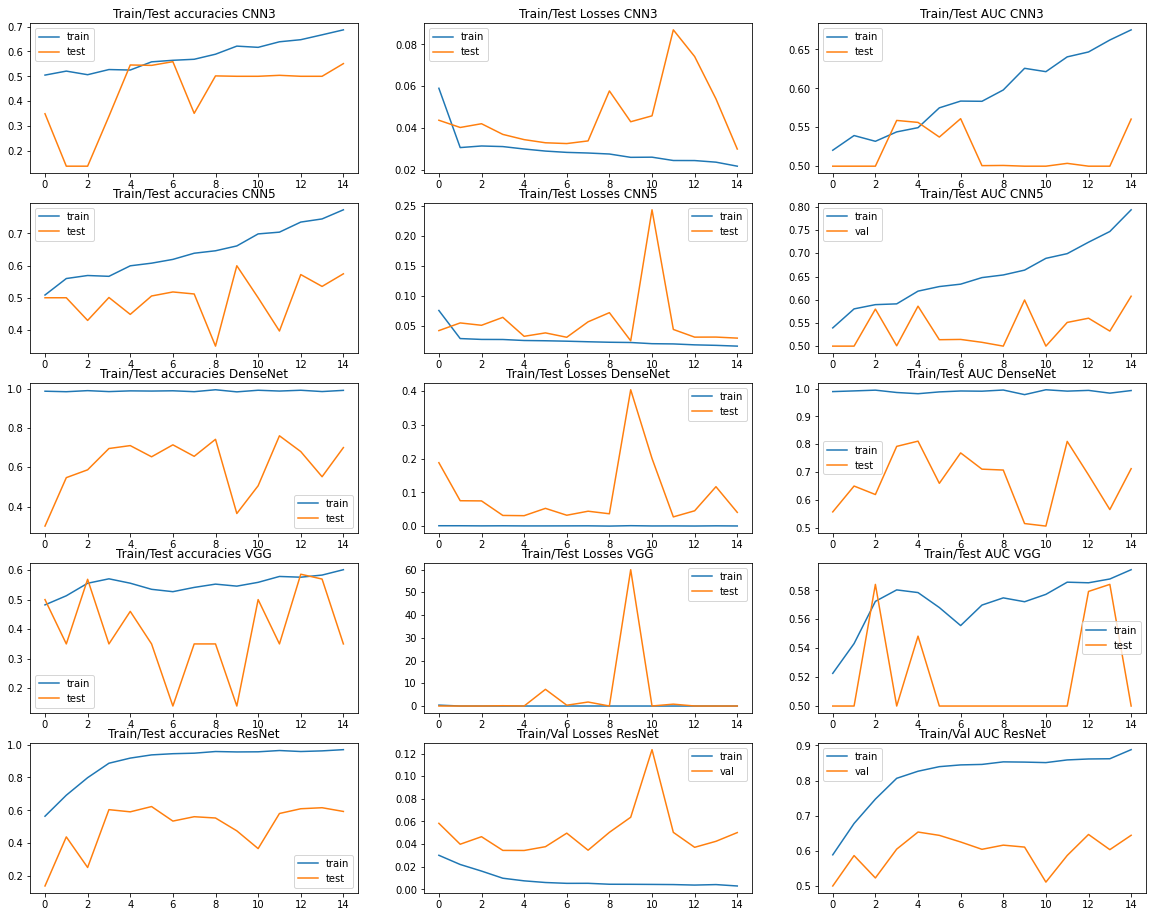

In [ ]:
# code for plotting the history of model train val loss, accuracy and AUC
f, axs = plt.subplots(5,3,figsize=(20,16))
axs[0,0].plot([tensor.item() for tensor in train_acc_history3], label="train")
axs[0,0].plot([tensor.item() for tensor in val_acc_history3], label="test")
axs[0,0].set_title("Train/Test accuracies CNN3")
axs[0,0].legend()
axs[0,1].plot(train_loss_history3, label="train")
axs[0,1].plot(val_loss_history3, label="test")
axs[0,1].set_title("Train/Test Losses CNN3")
axs[0,1].legend()
axs[0,2].plot(train_auc_history_3, label="train")
axs[0,2].plot(val_auc_history_3, label="test")
axs[0,2].set_title("Train/Test AUC CNN3")
axs[0,2].legend()

axs[1,0].plot([tensor.item() for tensor in train_acc_history5], label="train")
axs[1,0].plot([tensor.item() for tensor in val_acc_history5], label="test")
axs[1,0].set_title("Train/Test accuracies CNN5")
axs[1,0].legend()
axs[1,1].plot(train_loss_history5, label="train")
axs[1,1].plot(val_loss_history5, label="test")
axs[1,1].set_title("Train/Test Losses CNN5")
axs[1,1].legend()
axs[1,2].plot(train_auc_history_5, label="train")
axs[1,2].plot(val_auc_history_5, label="val")
axs[1,2].set_title("Train/Test AUC CNN5")
axs[1,2].legend()

axs[2,0].plot([tensor.item() for tensor in train_acc_history_d], label="train")
axs[2,0].plot([tensor.item() for tensor in val_acc_history_d], label="test")
axs[2,0].set_title("Train/Test accuracies DenseNet")
axs[2,0].legend()
axs[2,1].plot(train_loss_history_d, label="train")
axs[2,1].plot(val_loss_history_d, label="test")
axs[2,1].set_title("Train/Test Losses DenseNet")
axs[2,1].legend()
axs[2,2].plot(train_auc_history_d, label="train")
axs[2,2].plot(val_auc_history_d, label="test")
axs[2,2].set_title("Train/Test AUC DenseNet")
axs[2,2].legend()

axs[3,0].plot([tensor.item() for tensor in train_acc_history_v], label="train")
axs[3,0].plot([tensor.item() for tensor in val_acc_history_v], label="test")
axs[3,0].set_title("Train/Test accuracies VGG")
axs[3,0].legend()
axs[3,1].plot(train_loss_history_v, label="train")
axs[3,1].plot(val_loss_history_v, label="test")
axs[3,1].set_title("Train/Test Losses VGG")
axs[3,1].legend()
axs[3,2].plot(train_auc_history_v, label="train")
axs[3,2].plot(val_auc_history_v, label="test")
axs[3,2].set_title("Train/Test AUC VGG")
axs[3,2].legend()

axs[4,0].plot([tensor.item() for tensor in train_acc_history_r], label="train")
axs[4,0].plot([tensor.item() for tensor in val_acc_history_r], label="test")
axs[4,0].set_title("Train/Test accuracies ResNet")
axs[4,0].legend()
axs[4,1].plot(train_loss_history_r, label="train")
axs[4,1].plot(val_loss_history_r, label="val")
axs[4,1].set_title("Train/Val Losses ResNet")
axs[4,1].legend()
axs[4,2].plot(train_auc_history_r, label="train")
axs[4,2].plot(val_auc_history_r, label="val")
axs[4,2].set_title("Train/Val AUC ResNet")
axs[4,2].legend()

Test set accuracy = 55.9 %
Test set AUC = 0.561
Test set accuracy = 59.97 %
Test set AUC = 0.599
Test set accuracy = 76.08 %
Test set AUC = 0.81
Test set accuracy = 58.64 %
Test set AUC = 0.579
Test set accuracy = 62.31 %
Test set AUC = 0.644


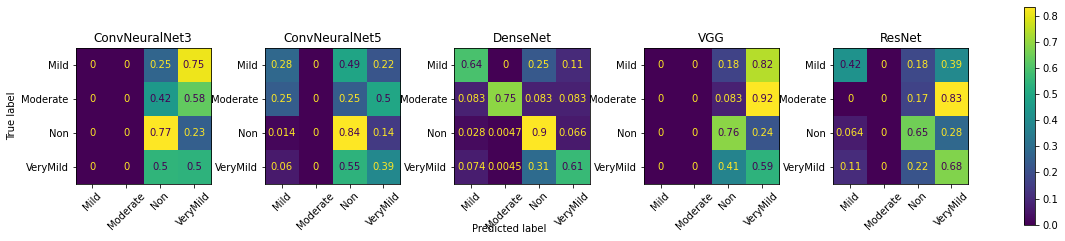

In [ ]:
display_results([model3_rms, model5_rms,model_d_rms,model_v_rms,model_r_rms])

Test set accuracy = 51.76 %
Test set AUC = 0.522


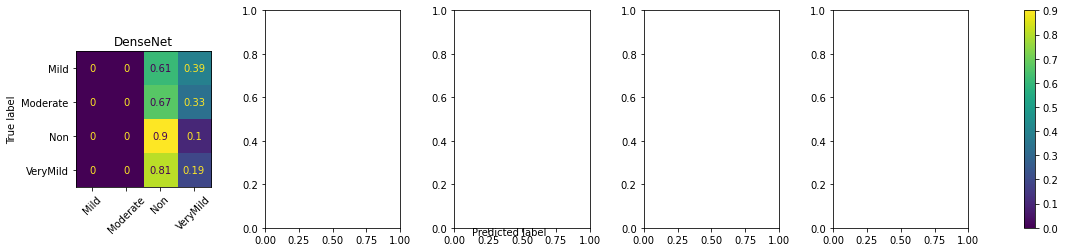

In [ ]:
display_results([model_d_rms])

In [ ]:
cnn3 = ConvNeuralNet3(num_classes).to(device)
cnn5 = ConvNeuralNet5(num_classes).to(device)
# 1000 is a fill-in parameter,not used by the models
densenet, input = initialize_model('densenet', num_classes, 1000, use_pretrained=True)
densenet = densenet.to(device)

vgg, input = initialize_model('vgg', num_classes, 1000, use_pretrained=True)
vgg = vgg.to(device)

resnet, input = initialize_model('resnet', num_classes, 1000, use_pretrained=True)
resnet = resnet.to(device)

# specify weighed loss with or without weighted loss
criterion = torch.nn.CrossEntropyLoss()
optimizer3 = torch.optim.SGD(cnn3.parameters(), lr=learning_rate,momentum=0.9, weight_decay=weight_decay)
optimizer5 = torch.optim.SGD(cnn5.parameters(), lr=learning_rate,momentum=0.9, weight_decay=weight_decay)
optimizer_densenet = torch.optim.SGD(densenet.parameters(), lr=learning_rate,momentum=0.9, weight_decay=weight_decay)
optimizer_vgg = torch.optim.SGD(vgg.parameters(), lr=0.01,momentum=0.9, weight_decay=weight_decay)
optimizer_resnet = torch.optim.SGD(resnet.parameters(), lr=learning_rate, weight_decay=weight_decay, momentum=0.9)

In [ ]:
model3_sgd, train_acc_history3, val_acc_history3, train_loss_history3, val_loss_history3, train_auc_history_3, val_auc_history_3 = train_model(cnn3, trainloader, criterion, optimizer3, epochs)
torch.cuda.empty_cache()

Epoch 0/14
----------
train Loss: 0.0331 Acc: 0.4991 Roc_auc: 0.5027 LR: 0.001
test Loss: 0.0313 Acc: 0.5199 Roc_auc: 0.5131 LR: 0.001
Evaluation
Epochs without improvement: 1

Epoch 1/14
----------
train Loss: 0.0310 Acc: 0.5114 Roc_auc: 0.5227 LR: 0.001
test Loss: 0.0322 Acc: 0.5278 Roc_auc: 0.5184 LR: 0.001
Evaluation
Epochs without improvement: 1

Epoch 2/14
----------
train Loss: 0.0298 Acc: 0.5343 Roc_auc: 0.5452 LR: 0.001
test Loss: 0.0305 Acc: 0.5317 Roc_auc: 0.5573 LR: 0.001
Evaluation
Epochs without improvement: 1

Epoch 3/14
----------
train Loss: 0.0292 Acc: 0.5489 Roc_auc: 0.5583 LR: 0.001
test Loss: 0.0313 Acc: 0.5332 Roc_auc: 0.5360 LR: 0.001
Evaluation
Epochs without improvement: 1

Epoch 4/14
----------
train Loss: 0.0288 Acc: 0.5475 Roc_auc: 0.5596 LR: 0.001
test Loss: 0.0323 Acc: 0.5184 Roc_auc: 0.5118 LR: 0.001
Evaluation
Epochs without improvement: 2

Epoch 5/14
----------
train Loss: 0.0286 Acc: 0.5643 Roc_auc: 0.5736 LR: 0.001
test Loss: 0.0304 Acc: 0.5113 Roc_au

In [ ]:
model5_sgd, train_acc_history5, val_acc_history5, train_loss_history5, val_loss_history5, train_auc_history_5, val_auc_history_5 = train_model(cnn5, trainloader, criterion, optimizer5, epochs)
torch.cuda.empty_cache()

Epoch 0/14
----------
train Loss: 0.0019 Acc: 0.9877 Roc_auc: 0.9687 LR: 0.001
test Loss: 0.0311 Acc: 0.6693 Roc_auc: 0.6320 LR: 0.001
Evaluation
Epochs without improvement: 1

Epoch 1/14
----------
train Loss: 0.0016 Acc: 0.9910 Roc_auc: 0.9642 LR: 0.001
test Loss: 0.0288 Acc: 0.6880 Roc_auc: 0.6534 LR: 0.001
Evaluation
Epochs without improvement: 1

Epoch 2/14
----------
train Loss: 0.0012 Acc: 0.9955 Roc_auc: 0.9853 LR: 0.001
test Loss: 0.0249 Acc: 0.6880 Roc_auc: 0.6596 LR: 0.001
Evaluation
Epochs without improvement: 2

Epoch 3/14
----------
train Loss: 0.0023 Acc: 0.9838 Roc_auc: 0.9757 LR: 0.001
test Loss: 0.0282 Acc: 0.6951 Roc_auc: 0.6523 LR: 0.001
Evaluation
Epochs without improvement: 1

Epoch 4/14
----------
train Loss: 0.0011 Acc: 0.9957 Roc_auc: 0.9832 LR: 0.001
test Loss: 0.0278 Acc: 0.6802 Roc_auc: 0.6526 LR: 0.001
Evaluation
Epochs without improvement: 2

Epoch 5/14
----------
train Loss: 0.0010 Acc: 0.9975 Roc_auc: 0.9961 LR: 0.001
test Loss: 0.0236 Acc: 0.7177 Roc_au

In [ ]:
model_d_sgd, train_acc_history_d, val_acc_history_d, train_loss_history_d, val_loss_history_d, train_auc_history_d, val_auc_history_d = train_model(densenet, trainloader, criterion, optimizer_densenet, epochs)
torch.cuda.empty_cache()

Epoch 0/14
----------
train Loss: 0.0317 Acc: 0.5185 Roc_auc: 0.5506 LR: 0.0001
test Loss: 0.0311 Acc: 0.5520 Roc_auc: 0.5579 LR: 0.0001
Evaluation
Epochs without improvement: 1

Epoch 1/14
----------
train Loss: 0.0242 Acc: 0.6661 Roc_auc: 0.6398 LR: 0.0001
test Loss: 0.0290 Acc: 0.5723 Roc_auc: 0.5724 LR: 0.0001
Evaluation
Epochs without improvement: 1

Epoch 2/14
----------
train Loss: 0.0190 Acc: 0.7698 Roc_auc: 0.7136 LR: 0.0001
test Loss: 0.0289 Acc: 0.5747 Roc_auc: 0.5857 LR: 0.0001
Evaluation
Epochs without improvement: 1

Epoch 3/14
----------
train Loss: 0.0152 Acc: 0.8489 Roc_auc: 0.7684 LR: 0.0001
test Loss: 0.0288 Acc: 0.6075 Roc_auc: 0.5862 LR: 0.0001
Evaluation
Epochs without improvement: 1

Epoch 4/14
----------
train Loss: 0.0113 Acc: 0.9039 Roc_auc: 0.8095 LR: 0.0001
test Loss: 0.0277 Acc: 0.5903 Roc_auc: 0.5979 LR: 0.0001
Evaluation
Epochs without improvement: 2

Epoch 5/14
----------
train Loss: 0.0085 Acc: 0.9469 Roc_auc: 0.8414 LR: 0.0001
test Loss: 0.0279 Acc: 0.

In [ ]:
model_v_sgd, train_acc_history_v, val_acc_history_v, train_loss_history_v, val_loss_history_v, train_auc_history_v, val_auc_history_v = train_model(vgg, trainloader, criterion, optimizer_vgg, epochs)
torch.cuda.empty_cache()

Epoch 0/29
----------
train Loss: 0.0228 Acc: 0.7043 Roc_auc: 0.6820 LR: 0.01
val Loss: 0.0278 Acc: 0.6386 Roc_auc: 0.6787 LR: 0.01
val
1

Epoch 1/29
----------
train Loss: 0.0125 Acc: 0.8455 Roc_auc: 0.7793 LR: 0.01
val Loss: 0.0347 Acc: 0.5395 Roc_auc: 0.5685 LR: 0.01
val
2

Epoch 2/29
----------
train Loss: 0.0065 Acc: 0.9258 Roc_auc: 0.8581 LR: 0.01
val Loss: 0.0260 Acc: 0.6891 Roc_auc: 0.7012 LR: 0.01
val
1

Epoch 3/29
----------
train Loss: 0.0057 Acc: 0.9353 Roc_auc: 0.9304 LR: 0.01
val Loss: 0.0371 Acc: 0.5827 Roc_auc: 0.5989 LR: 0.01
val
2

Epoch 4/29
----------
train Loss: 0.0046 Acc: 0.9509 Roc_auc: 0.9552 LR: 0.01
val Loss: 0.1121 Acc: 0.4858 Roc_auc: 0.5226 LR: 0.01
val
3

Epoch 5/29
----------
train Loss: 0.0029 Acc: 0.9657 Roc_auc: 0.9751 LR: 0.01
val Loss: 0.0569 Acc: 0.4531 Roc_auc: 0.5402 LR: 0.01
val
4

Epoch 6/29
----------
train Loss: 0.0032 Acc: 0.9651 Roc_auc: 0.9693 LR: 0.001
val Loss: 0.0699 Acc: 0.5564 Roc_auc: 0.5786 LR: 0.001
val
5

Epoch 7/29
----------
tra

In [ ]:
model_r_sgd, train_acc_history_r, val_acc_history_r, train_loss_history_r, val_loss_history_r, train_auc_history_r, val_auc_history_r = train_model(resnet, trainloader, criterion, optimizer_resnet, epochs)
torch.cuda.empty_cache()

Epoch 0/14
----------
train Loss: 0.0251 Acc: 0.6471 Roc_auc: 0.6367 LR: 0.0005
test Loss: 0.0340 Acc: 0.5817 Roc_auc: 0.5580 LR: 0.0005
Evaluation
Epochs without improvement: 1

Epoch 1/14
----------
train Loss: 0.0104 Acc: 0.8893 Roc_auc: 0.8060 LR: 0.0005
test Loss: 0.0276 Acc: 0.6474 Roc_auc: 0.6487 LR: 0.0005
Evaluation
Epochs without improvement: 1

Epoch 2/14
----------
train Loss: 0.0041 Acc: 0.9732 Roc_auc: 0.9087 LR: 0.0005
test Loss: 0.0340 Acc: 0.6802 Roc_auc: 0.6447 LR: 0.0005
Evaluation
Epochs without improvement: 1

Epoch 3/14
----------
train Loss: 0.0019 Acc: 0.9906 Roc_auc: 0.9662 LR: 0.0005
test Loss: 0.0382 Acc: 0.6661 Roc_auc: 0.6476 LR: 0.0005
Evaluation
Epochs without improvement: 2

Epoch 4/14
----------
train Loss: 0.0011 Acc: 0.9957 Roc_auc: 0.9926 LR: 0.0005
test Loss: 0.0329 Acc: 0.6896 Roc_auc: 0.6887 LR: 0.0005
Evaluation
Epochs without improvement: 1

Epoch 5/14
----------
train Loss: 0.0008 Acc: 0.9967 Roc_auc: 0.9980 LR: 0.0005
test Loss: 0.0383 Acc: 0.

Test set accuracy = 56.37 %
Test set AUC = 0.566
Test set accuracy = 71.85 %
Test set AUC = 0.701
Test set accuracy = 66.69 %
Test set AUC = 0.644
Test set accuracy = 76.23 %
Test set AUC = 0.746
Test set accuracy = 71.62 %
Test set AUC = 0.713


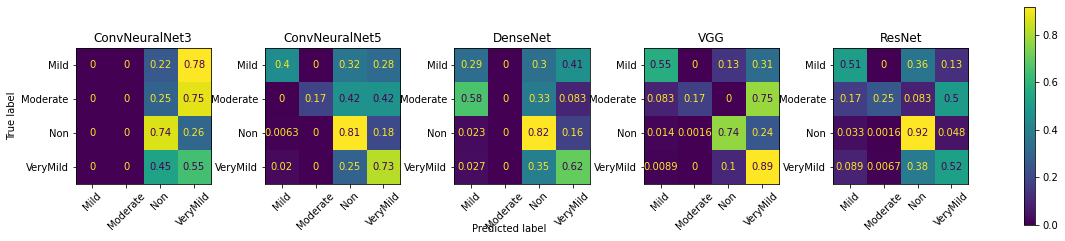

In [ ]:
display_results([model3_sgd, model5_sgd,model_d_sgd,model_v_sgd,model_r_sgd])

Test set accuracy = 50.04 %
Test set AUC = 0.5


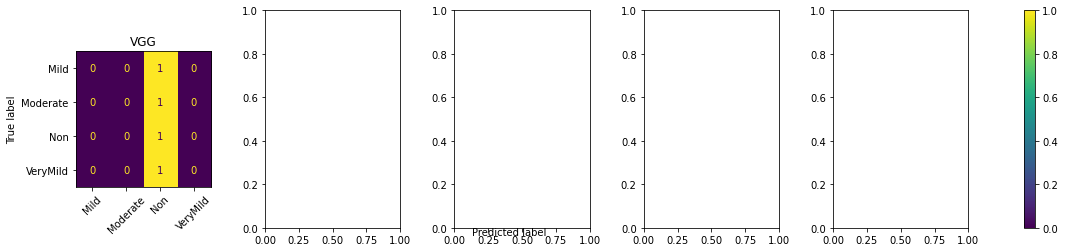

In [ ]:
display_results([model_v_sgd])